In [1]:
import sys  
sys.path.insert(0, '../')

import matplotlib.pyplot as plt
from src.utils.plot_utils import *
from src.datamodules.datasets.handpose_dataset import HandposeDataset
from src.datamodules.default_datamodule import DefaultDataModule
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage, functional
from PIL import Image
from typing import Any

In [2]:
data = HandposeDataset(root="../data")

Preprocessing handpose dataset...
Done, preprocessed 110704 data points (train=True).


In [3]:
def plot_hand(img, K, kp3d):
    kp2d = kp3d_to_kp2d(kp3d, K)
    return plot_fingers2D(kp2d, img_rgb=img)

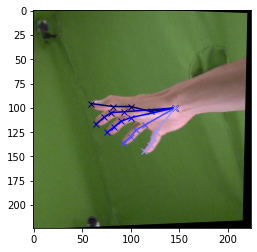

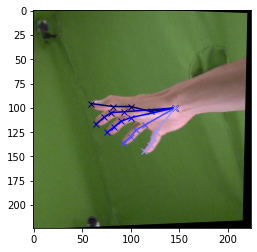

In [4]:
plot_hand(*data[0])

In [5]:
from src.datamodules.transforms import transforms

In [6]:
trans = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5), 
            transforms.RandomRotation(degrees=60), 
            transforms.ColorJitter(brightness=0.1, contrast=0.1)
        ])

In [7]:
data = HandposeDataset(root="../data", train=True, transforms_pair=trans)

Preprocessing handpose dataset...
Done, preprocessed 110704 data points (train=True).


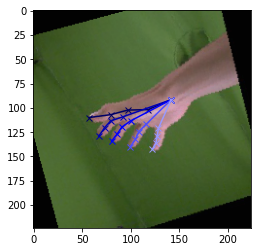

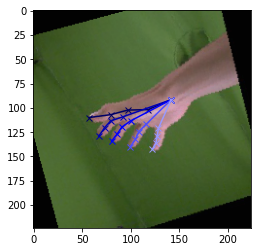

In [8]:
plot_hand(*data[0])

In [32]:
# import cv2
from scipy.ndimage import affine_transform
from torchvision.transforms import functional as F
from PIL import Image

def h_flip_points(points):
    points = points.clone()
    points[:,0] = points[:,0] * -1
    return points

def v_flip_points(points):
    points = points.clone()
    points[:,1] = points[:,1] * -1
    return points

def points_3d_to_2d(points, cam):
    f_x = cam[0,0]
    f_y = cam[1,1]
    o_x = cam[0,2]
    o_y = cam[1,2]

    points_2d = points.clone()
    points_2d[:,0] = f_x * points_2d[:,0] / points[:,2] + o_x
    points_2d[:,1] = f_y * points_2d[:,1] / points[:,2] + o_y
    
    return points_2d

def points_2d_to_3d(points, cam):
    f_x = cam[0,0]
    f_y = cam[1,1]
    o_x = cam[0,2]
    o_y = cam[1,2]

    points_3d = points.clone()
    points_3d[:,0] = (points_3d[:,0]-o_x) * points[:,2] / f_x 
    points_3d[:,1] = (points_3d[:,1]-o_y) * points[:,2] / f_y 
    
    return points_3d
    

def transform_points(points, T, cam):
    points_2d = points_3d_to_2d(points, cam)
    points_2d[:, 2] = 1
    transformed = points_2d @ T.T
    transformed[:, 2] = points[:, 2]
    points_3d = points_2d_to_3d(transformed, cam)
    return points_3d

    

def transform_image(img, angle=0, translate=(0,0), scale=1):
    transformed = F.affine(img, angle, translate, scale, 0, interpolation=F.InterpolationMode.BILINEAR)
    return transformed


class RandomVerticalFlip:
    """
    Randomly flips image and 3d points horizontally.
    """

    def __init__(self, p: float = 0.5) -> None:
        self.p = p

    def __call__(self, img, points, cam) -> Any:
        if torch.rand(1) > self.p:
            img = F.vflip(img)
            points = v_flip_points(points)

        return img, points, cam
    

class RandomScale:
    def __init__(self, scale_range=(0.8,1.2)) -> None:
        self.scale_range = scale_range

    def __call__(self, img, points, cam) -> Any:
        factor = np.random.uniform(*self.scale_range)
        shift = np.array(img.size)/2
        
        # Shift center to (0,0), scale, shift back
        T = np.array([
            [1,0,shift[0]],
            [0,1,shift[1]],
            [0,0,1]
        ], dtype=np.float64) @ np.array([
            [factor,0,0],
            [0,factor,0],
            [0,0,1]
        ]) @ np.array([
            [1,0,-shift[0]],
            [0,1,-shift[1]],
            [0,0,1]
        ], dtype=np.float64)
        
        img = transform_image(img, scale=factor)
        points = transform_points(points, T, cam)

        return img, points, cam
    
class RandomTranslation:
    """
    Shifts image and points horizontally and vertically.
    Horizontal shift is by pixel value chosen uniformly from [-horizontal, horizontal].
    Vertical shift is by pixel value chosen uniformly from [-vertical, vertical].
    """
    def __init__(self, horizontal=10, vertical=10) -> None:
        self.horizontal = horizontal
        self.vertical = vertical

    def __call__(self, img, points, cam) -> Any:
        
        
        T = np.array([
            [1,0,self.horizontal],
            [0,1,self.vertical],
            [0,0,1]
        ], dtype=np.float64)
        
        img = transform_image(img, translate=(self.horizontal, self.vertical))
        points = transform_points(points, T, cam)

        return img, points, cam
    
class Identity:
    def __call__(self, img, points, cam) -> Any:
        return img, points, cam

In [13]:
data = HandposeDataset(root="../data", train=True, transforms_pair=None)

Preprocessing handpose dataset...
Done, preprocessed 110704 data points (train=True).


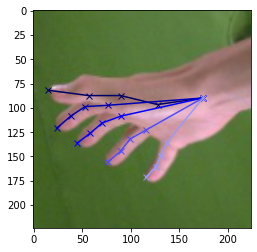

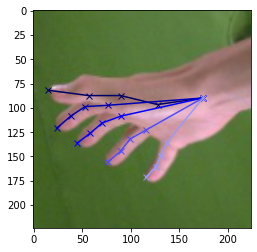

In [14]:
img, cam, points = data[0]
img, points, cam = RandomScale((1.4,2.0))(img, points, cam)
plot_hand(img, cam, points)

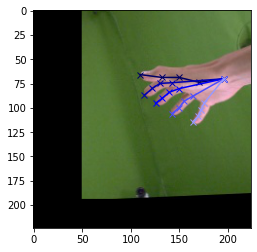

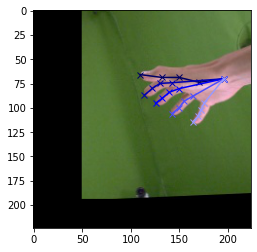

In [15]:
img, cam, points = data[0]
img, points, cam = RandomTranslation(50,-30)(img, points, cam)
plot_hand(img, cam, points)

In [45]:
trans = transforms.RandomChoiceCompose([
            RandomVerticalFlip(p=0.5), 
            transforms.RandomHorizontalFlip(0.5), 
            RandomScale((0.8,1.2)),
            RandomTranslation(30,30),
            transforms.RandomRotation(degrees=180),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            Identity()
        ])
data = HandposeDataset(root="../data", train=True,transforms_pair=trans)

Preprocessing handpose dataset...
Done, preprocessed 110704 data points (train=True).


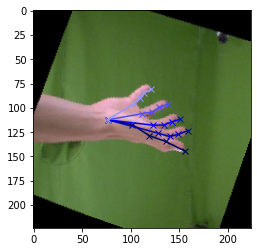

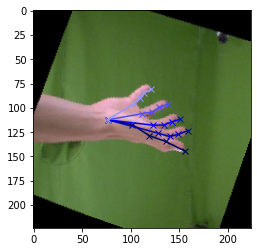

In [46]:
plot_hand(*data[0])